In [20]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (15,10)

SOURCE_PATH = os.getcwd()
INPUTS_PATH = os.path.join(SOURCE_PATH, "data", "inputs")
OUTPUTS_PATH = os.path.join(SOURCE_PATH, "data", "outputs")
DATASET_NAMES = ["betadgp_covdgp_data", "betadgp_beta2x2_data", "betadgp_data"]
TARGET_NAME = "betas_dgp"
MODEL_TAGS = ["ffnn", "linear_reg"]

## 1) Aggregate all results

In [2]:
all_data = []
for model_tag in tqdm(MODEL_TAGS,
                      desc="Append all model results"):
    
    DGPS = os.listdir(os.path.join(OUTPUTS_PATH, model_tag))
    for dgp_name in DGPS:
        for ds in DATASET_NAMES:
            
            data = pd.read_csv(os.path.join(OUTPUTS_PATH, model_tag, dgp_name, ds + "_result.csv"))
            data["model"] = model_tag
            data["dgp"] = dgp_name
            data["dataset"] = ds
            
            all_data.append(data)
all_data_df = pd.concat(all_data, axis=0)

Append all model results: 100%|██████████| 2/2 [00:01<00:00,  1.14it/s]


In [ ]:
ffnn_achitectures = []
for model_tag in tqdm(MODEL_TAGS,
                      desc="Append all model results"):
    
    DGPS = os.listdir(os.path.join(OUTPUTS_PATH, model_tag))
    for dgp_name in DGPS:
        for ds in DATASET_NAMES:
            
             ffnn_tmp = pyutils.save_pkl(data=model_search.best_params_,
                                         path=os.path.join(outputs_path, model_tag, dir_name, d_name + "_model.pickle"))
            data["model"] = model_tag
            data["dgp"] = dgp_name
            data["dataset"] = ds
            
            all_data.append(data)
all_data_df = pd.concat(all_data, axis=0)

In [3]:
all_data_df.tail()

,Var1,Var2,y,pred,model,dgp,dataset
9995,100,96,-0.16418,0.001744,linear_reg,ar1_171_random,betadgp_data
9996,100,97,0.00000,0.002575,linear_reg,ar1_171_random,betadgp_data
9997,100,98,0.00000,0.003036,linear_reg,ar1_171_random,betadgp_data
9998,100,99,0.00000,0.002516,linear_reg,ar1_171_random,betadgp_data
9999,100,100,0.00000,-0.006609,linear_reg,ar1_171_random,betadgp_data


## 2) Compute relevant metrics

> a) Mean squared error

> b) Mean absolute error

In [4]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def mse_melt(v):
    mse = mean_squared_error(y_true=v["y"],
                             y_pred=v["pred"])
    return pd.Series(dict(mse=mse))

def mae_melt(v):
    mae = mean_absolute_error(y_true=v["y"],
                             y_pred=v["pred"])
    return pd.Series(dict(mae=mae))

metrics_df = all_data_df.drop(["Var1", "Var2"], axis=1)
mse_group_df = metrics_df.groupby(["model", "dgp", "dataset"]).apply(mse_melt).reset_index()
mae_group_df = metrics_df.groupby(["model", "dgp", "dataset"]).apply(mae_melt).reset_index()

### MSE histogram

Text(0.5, 1.0, 'MSE of the OOS forecast for each test simulation')

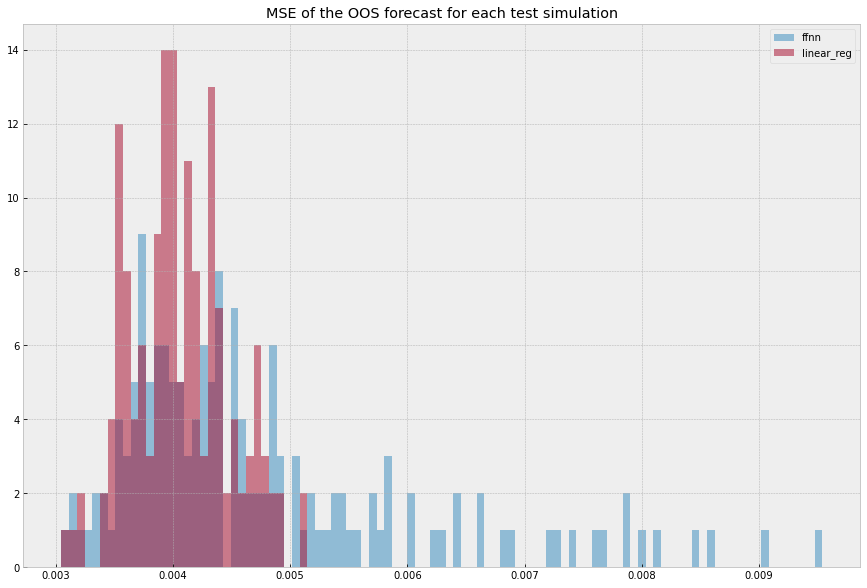

In [33]:
ffnn_hist_mse = mse_group_df.loc[mse_group_df["model"]=="ffnn"][["mse"]]
ffnn_hist_mse.rename(columns={"mse": "ffnn mse"}, inplace=True)

linear_reg_hist_mse = mse_group_df.loc[mse_group_df["model"]=="linear_reg"][["mse"]]
linear_reg_hist_mse.rename(columns={"mse": "linear_reg mse"}, inplace=True)

hist_mse_df = pd.concat([ffnn_hist_mse.reset_index(drop=True), linear_reg_hist_mse.reset_index(drop=True)], axis=1)

bins = np.linspace(hist_mse_df.min().min(), hist_mse_df.max().max(), 100)
plt.hist(hist_mse_df[hist_mse_df.columns[0]], bins, alpha=0.5, label='ffnn')
plt.hist(hist_mse_df[hist_mse_df.columns[1]], bins, alpha=0.5, label='linear_reg')
plt.legend(loc='upper right')
plt.title("MSE of the OOS forecast for each test simulation")

### MAE histogram

Text(0.5, 1.0, 'MAE of the OOS forecast for each test simulation')

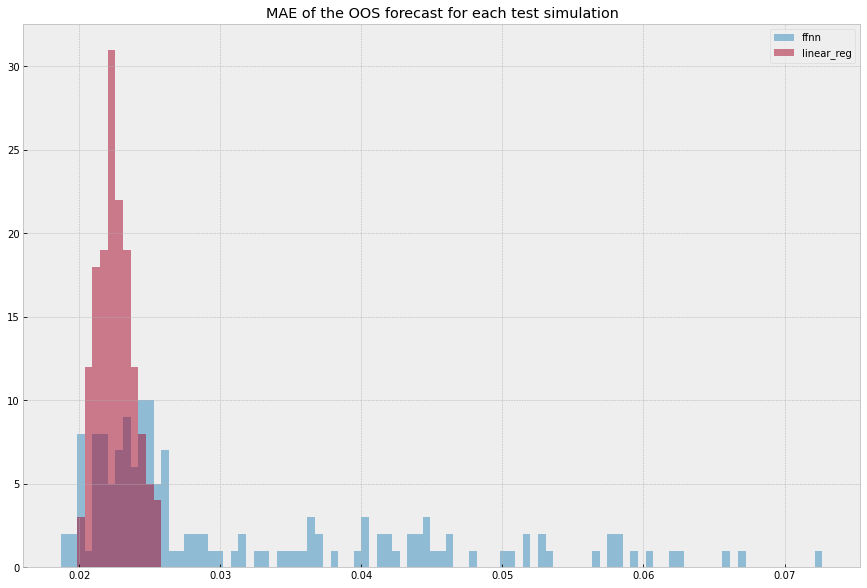

In [32]:
ffnn_hist_mae = mae_group_df.loc[mae_group_df["model"]=="ffnn"][["mae"]]
ffnn_hist_mae.rename(columns={"mae": "ffnn mae"}, inplace=True)

linear_reg_hist_mae = mae_group_df.loc[mae_group_df["model"]=="linear_reg"][["mae"]]
linear_reg_hist_mae.rename(columns={"mae": "linear_reg mae"}, inplace=True)

hist_mae_df = pd.concat([ffnn_hist_mae.reset_index(drop=True), linear_reg_hist_mae.reset_index(drop=True)], axis=1)

bins = np.linspace(hist_mae_df.min().min(), hist_mae_df.max().max(), 100)
plt.hist(hist_mae_df[hist_mae_df.columns[0]], bins, alpha=0.5, label='ffnn')
plt.hist(hist_mae_df[hist_mae_df.columns[1]], bins, alpha=0.5, label='linear_reg')
plt.legend(loc='upper right')
plt.title("MAE of the OOS forecast for each test simulation")

## 3) Analysis of the chosen FFNN architectures